# SELECTED_ASSI_FIELD_INVESTIGATOR
'''''' The script brings in ASSI data and finds "fields" within the user defined distance from the user selected ASSI.
        The script then summarise a number of dummy field attributes -joined from a separate table to the 'agricultural fields           (aka small areas)' data,-within the ASSI buffer area, to provide a profile of the buffer area.
''''''


Name of ASSI to investigate:
Lough Foyle
Specify a buffer distance in kilometers. 
Input a whole number:
2


<IPython.core.display.Javascript object>


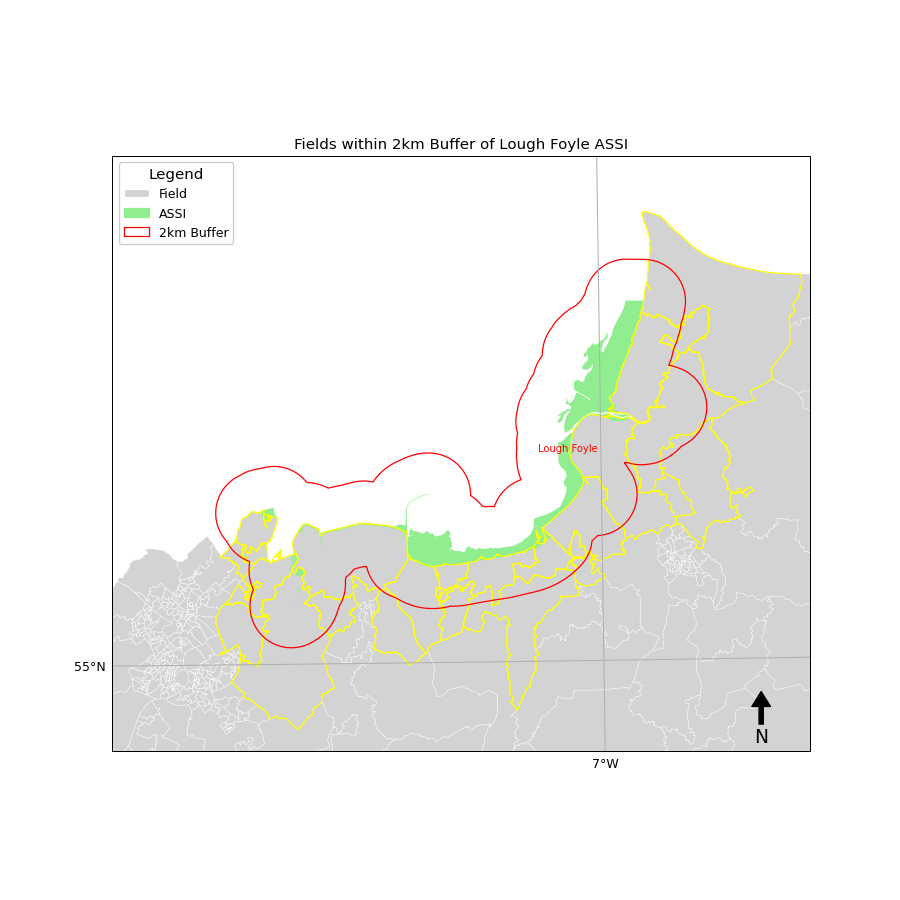

C:\Users\carol\AppData\Local\Temp\ipykernel_22228\862755983.py:262: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  FieldsInBuf.to_file(S_OutputName+"_Fields.shp")


In [1]:
##################################################### Selected ASSI###########################################################
####################################### Import required modules/packages/dependencies##########################################
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs

import cartopy
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import folium
import ipywidgets
#from IPython.display import HTML, display
import numpy as np
from __future__ import division
import openpyxl
   
################################################# Essential User Input ######################################################
#first ask for user input to select an ASSI to investigate
print("Name of ASSI to investigate:")
Selected_ASSI = input()

#then ask user to determine the buffer distance to be used
print("Specify a buffer distance in kilometers. \nInput a whole number:")
Dist_km_str = input()
Dist_km_int = int(Dist_km_str)
Dist_m_int = Dist_km_int*1000


################################################# New functions ############################################################

# This "assign_Area_Length" function assigns area in km2 and length in meters to any geodataframe
def assign_Area_Length(gdf):
    for ind, row in gdf.iterrows(): # iterate over each row in the GeoDataFrame
        gdf.loc[ind, 'Area_km2'] = row['geometry'].area / 1000000 # assign the row's geometry length to a new column, Area
    
    for ind, row in gdf.iterrows(): # iterate over each row in the GeoDataFrame
        gdf.loc[ind, 'Length_m'] = row['geometry'].length  # assign the row's geometry length to a new column, Length

# This function retuns the top x number of rows within a gdf, with highest values within a user defined column
def topFeatures(gdf, columnNAme, number):
    #to get the top 10 values of a field:
    top_Features = gdf.sort_values(columnNAme, ascending=False).head(int(number))
    return top_Features

     
################################################# Initial Data SetUp ############################################################


#- - - - - - - - - - - - - - - - - - - - Bring in the key spatial datasets- - - - - - - - - - - - - - - - - - - - - - - - 
# adding the ASSI data
ASSI = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project//data_files/ASSI.shp')).to_crs(epsg=2157)
assign_Area_Length(ASSI) #apply user created function to assign lenght and area to gdf
ASSI = ASSI.drop(['MAP_SCALE', 'CONFIRMDAY', 'CONFIRM_HA', 'DECLAREDAY','DECLARE_HA',
                  'GIS_AREA', 'GIS_LENGTH', 'PARTIES', 'Shape_STAr', 'Shape_STLe', 'Hyperlink'], axis=1)    #Drop unneccessary fields

newASSIorder = ['OBJECTID','geometry', 'REFERENCE',  'NAME', 'COUNTY', 'SPECIESPT1', 'SPECIESPT2', #Create new order for columns
                  'HABITAT', 'EARTH_SCI', 'Area_km2', 'Length_m']                   
ASSI= ASSI.reindex(columns=newASSIorder)                               

# add Agricultural fields data
AgFields = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/EGM722_Project/data_files/AgFields.shp'))
AgFields.to_crs(epsg=2157, inplace=True)

assign_Area_Length(AgFields)             #apply user created function to assign length and area to gdf
newAgFieldsorder = ['geometry', 'FieldID',  'Hectares', 'Area_km2', 'Length_m', 'X_COORD', 'Y_COORD']  #Create new order for columns
                                       
AgFields= AgFields.reindex(columns=newAgFieldsorder)   

#Add second Agri dataset (inc.Field ID's and animal counts)
FieldInfo =  pd.read_excel(os.path.abspath('C:/Carol_PG_CERT_GIS/EGM722_Project/data_files/FieldInfo.xlsx')) #Add in excel table to join data

#join FieldInfo (pandas dataframe) onto the AgFields(geopandas dataframe)
AgFields = AgFields.merge(FieldInfo, on='FieldID', how='left')
AgFields = AgFields.drop(['X_COORD', 'Y_COORD'], axis=1) # drop unrequired columns


#################Initial spatial analysis to create a user defined buffer of selected ASSIs ###########################
#create an GDF based upon the User selected ASSI
SelectedASSI = ASSI.loc[ASSI['NAME'] == Selected_ASSI]

#create an ASSI Buffer GDF based upon the User selected Buffer Distance
SelectedASSI_buffer = SelectedASSI.copy()
SelectedASSI_buffer.geometry = SelectedASSI.geometry.buffer(Dist_m_int)


################################################### overlay fields with buffer ###################################################
FieldsInBuf = gpd.sjoin(AgFields,SelectedASSI_buffer,how='inner',predicate='intersects',) 



######################## Create output map to show ASSI, Buffer extent and Fields within Buffer extent #########################
%matplotlib notebook
# make the plotting interactive
#plt.ion()

# create the applicable CRS -in this case- Universal Transverse Mercator reference system- to transform the data
myCRS = ccrs.epsg(2157)

# create a figure of size 10x10 (representing the page size in inches)
myFig = plt.figure(figsize=(10, 10)) 

# create an axes object in the figure (within which the data shall be plotted), using the predefined crs
ax = plt.axes(projection=myCRS)  

# first, we set the map extent
xmin, ymin, xmax, ymax = SelectedASSI.total_bounds #then get this dataset bounds and set them against the axes extent '
mapExtent = ax.set_extent([xmin-Dist_m_int-5000, xmax+Dist_m_int+5000, ymin-Dist_m_int-5000, ymax+Dist_m_int+5000], crs=myCRS)


###- - - - - - - - - - - - - - -  Add background features to map (for aesthetic/contest setting purposes only) - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -
#ax.add_feature(cartopy.feature.OCEAN) Search for better, as the resolution/ accuracy of these , is not great
#request = cimgt.OSM()
#ax.add_image(request, 8)

###- - - - - - - - - - - - - - -  Add required data to the map- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -

#Create Shapely features to add to the map:
SelectedASSI_feature = ShapelyFeature(SelectedASSI['geometry'], myCRS, edgecolor='none', facecolor='lightgreen', linewidth=1)
SelectedASSI_buffer_feature = ShapelyFeature(SelectedASSI_buffer['geometry'], myCRS, edgecolor='red', facecolor='none', linewidth=1)
FieldsInBuf_feature = ShapelyFeature(FieldsInBuf['geometry'], myCRS, edgecolor='yellow', facecolor='none', linewidth=1)
AgFields_feature = ShapelyFeature(AgFields['geometry'], myCRS, edgecolor='w', facecolor='lightgrey', linewidth=0.3)

#Add Shapely features to the map:
ax.add_feature(AgFields_feature)               # add the Field data to map
ax.add_feature(SelectedASSI_feature)           # add the ASSI data to map
ax.add_feature(FieldsInBuf_feature)            # add the Selected Field data to map
ax.add_feature(SelectedASSI_buffer_feature)    # add selected ASSI 3km Buffer to map:
   
###- - - - - - - - - - - - - - - - - - --add legend  to the map- - - - - - - - - - - - - - -- - - - - - - -- - - - - - - -

# create handles for the legend:
ASSI_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgreen', edgecolor='lightgreen')]
ASSI_buffer_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='r')]
AgField_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='lightgrey', edgecolor='w')]

handles =  AgField_handles + ASSI_handles + ASSI_buffer_handles  #generate a list of handles for the legend
labels = ['Field','ASSI', (str(Dist_km_int)+'km Buffer')]        #generate a list of lables for the legend

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                fontsize=10, loc='upper left', frameon=True, framealpha=1) #assign legend paramenters to variable 'leg'


#-----------------------------------------add gridlines:-----------------------------------------------------------------------

gridlines = ax.gridlines(draw_labels=True,  # draw  labels for the grid lines
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],  # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55, 55.5])  # add latitude lines at 0.5 deg intervals
gridlines.right_labels = False  # turn off the left-side labels
gridlines.top_labels = False  # turn off the bottom labels
gridlines.left_labels = True  # turn on the left-side labels
gridlines.bottom_labels = True  # turn on the bottom labels

###- - - - - - - - - - - - - - - ------ add lables to the map- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - --
#add ASSI label to map- this first requires x,yco-ords to be assigned to the feature(s)
ASSI["x"] = ASSI.centroid.map(lambda p: p.x)
ASSI["y"] = ASSI.centroid.map(lambda p: p.y)
for ind, row in ASSI.loc[ASSI['NAME'] == Selected_ASSI].iterrows():  # ASSI.iterrows() returns the index and row
    x, y = row.x, row.y  # get the x,y location for each town
    ax.text(x, y, row['NAME'].title(), fontsize=8, color ='red', transform=myCRS)  # use plt.text to place a label at x,y
    

#-----------------------------add a north arrow:----------------------------------------------------------------------------------

x, y, arrow_length = 0.93, 0.1, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor="black", width=3.5, headwidth=15),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)


#-----------------------------add a title:--------------------------------------------------------------------------------    --

ax.set_title("Fields within " + str(Dist_km_int)+ "km Buffer of "+ Selected_ASSI +" ASSI");

    
#-----------------------------------------add a scale bar:-----------------------------------------------------------------------
        
#TODO - FIx Scale bar This "scale_bar" function creates a scale bar 10km wide, broken down by 1km and 5km
#def scale_bar(ax, location=(0.1, 0.05)):
#    x0, x1, y0, y1 = ax.get_extent()
#    sbx = x0 + (x1 - x0) * location[0]
#    sby = y0 + (y1 - y0) * location[1]
#    #sbx = x0 + (x1 - x0) * location[0]
#    #sby = y0 + (y1 - y0) * location[1]

#    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=7, transform=ax.projection)
#    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
#    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)
#    ax.plot([sbx-9000, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)

#    ax.text(sbx, sby-4500, '10 km', transform=ax.projection, fontsize=6)
#    ax.text(sbx-4250, sby-4500, '5', transform=ax.projection, fontsize=6)#should be 6250 but doesn't place well
#    ax.text(sbx-9750, sby-4500, '1', transform=ax.projection, fontsize=6)# should be 11250 but doesn't place well
#    ax.text(sbx-12500, sby-4500, '0', transform=ax.projection, fontsize=6)# add the scale bar to the axis
#scale_bar(ax)


#First To create a relevant filename (based on ASSI Reference) to use for saving ma, excel and shapefile outputs, first
ASSICode = str(FieldsInBuf.REFERENCE.unique())
ASSICode = ASSICode.replace("[", "")
ASSICode = ASSICode.replace("]", "")
ASSICode = ASSICode.replace("'","")

#then use the ASSICode to create the prefix name for any output:
S_OutputName =ASSICode+"_"+ str(Dist_km_int)+ "km_" + Selected_ASSI


#--------------------------------------Output stats to text file---------------------------------------------------------------
total_Area = AgFields.area.sum()/1000000# Total area of all fields
total_Area_inside = FieldsInBuf.area.sum()/1000000 # total area of fields falling within the BUFFER
total_Area_outside = total_Area -total_Area_inside # total area of fields falling outside the BUFFER
percentAllFields=total_Area/total_Area*100
percentFieldsInside=total_Area_inside/total_Area*100
percentFieldsOutside=100-percentFieldsInside
NIPigCount=FieldInfo['Pig_Count'].sum()
NICattleCount=FieldInfo['Pig_Count'].sum()
NIPoultryHouseCount =FieldInfo['PoultryHouses'].sum()
totalPigCount= FieldsInBuf['Pig_Count'].sum()
total_CattleCount= FieldsInBuf['Pig_Count'].sum()
totalPoultyHouses= FieldsInBuf['PoultryHouses'].sum()
percentPigCount= totalPigCount/NIPigCount*100
percentCattleCount= total_CattleCount/total_CattleCount*100
percentPoultryHouses= totalPoultyHouses/NIPoultryHouseCount*100
AvPigCount= FieldsInBuf['Pig_Count'].mean()
AvCattleCount= FieldsInBuf['Cattle_Count'].mean()
AvPoultyHouses= FieldsInBuf['PoultryHouses'].mean()

with open(S_OutputName + "_Results.txt", "a") as f:
  print("Field Info:", file=f) 
  print("Total area of all fields :                                                  {:.0f} km2".format(total_Area), file=f)
  print("Total area of all fields falling within / partially within " +str(Dist_km_int)+"km of" +Selected_ASSI+":  {:.0f} km2".format(total_Area_inside), file=f)
  print("Total area of all fields falling entirely outside of " +str(Dist_km_int)+"km from "+Selected_ASSI+":      {:.0f} km2".format(total_Area_outside), file=f)
  print(" ", file=f)
  print("Animal Info: ", file=f)
  print("Total count of pigs within/ partially within the " +str(Dist_km_int)+"km buffer:                 {:.0f} pigs".format(totalPigCount), file=f)
  print("Total count of cattle within/ partially within the " +str(Dist_km_int)+"km buffer:               {:.0f} cattle".format(total_CattleCount), file=f)
  print("Total count of poultry houses within/ partially within the " +str(Dist_km_int)+"km buffer:        {:.0f} poultry houses".format(totalPoultyHouses), file=f)
  print(" ", file=f)
  print(" ", file=f)
  print("Mean number of pigs in fields within/ partially within the " +str(Dist_km_int)+"km"+Selected_ASSI+" buffer:                     {:.0f} pigs".format(AvPigCount), file=f)
  print("Mean number of cattle in fields within/ partially within the " +str(Dist_km_int)+"km"+Selected_ASSI+" buffer:                  {:.0f} cattle".format(AvCattleCount), file=f)
  print("Mean number of poultry houses in fields within/ partially within the " +str(Dist_km_int)+"km"+Selected_ASSI+" buffer:           {:.0f} poultry houses".format(AvPoultyHouses), file=f)
  print(" ", file=f)
  print(" ", file=f)  
  print(" ", file=f)
  print(" ", file=f) 
  print("Descriptive Statistics for fields within "+ str(Dist_km_int)+"km of "+Selected_ASSI+" ASSI", file=f)
  print(" ", file=f) 
  print(FieldsInBuf.describe(),file=f)  


#------------------------save the map image, spatial data and tabular output, to png, shp and xlsx respectively: ---------------------------------------------------------------------------------

myFig.savefig(S_OutputName+'_map.png', dpi=300, bbox_inches='tight')
SelectedASSI.to_file(ASSICode+ '_' +Selected_ASSI+"_ASSI.shp")          
SelectedASSI_buffer.to_file(S_OutputName+"_Buffer.shp")
FieldsInBuf.to_file(S_OutputName+"_Fields.shp")

#Drop unrequired fields before exporting to excel
xlsx_S_FieldOutput = FieldsInBuf.drop(['geometry', 'index_right', 'OBJECTID', 'REFERENCE', 'NAME', 'COUNTY', 'SPECIESPT1', 'SPECIESPT2', 'HABITAT', 'EARTH_SCI', 'Area_km2_right', 'Length_m_right'], axis=1)
xlsx_S_FieldOutput= xlsx_S_FieldOutput.rename(columns={'Area_km2_left': 'Area_km2', 'Length_m_left': 'Length_m'})
xlsx_S_FieldOutput.to_excel(S_OutputName+"_Fields.xlsx") # exports the features to an excel file for future use (if required)

